In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# 2. Loads Images

In [ ]:
#Setting some inital parameters
height, width = 299, 299
batch_size=64

In [ ]:
data_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/train'
def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
            classes={'no': 0., 'yes': 1.}
            )
    return train_ds, val_ds

train_ds, val_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 1621 images belonging to 2 classes.
Found 405 images belonging to 2 classes.

 {'No_brain_tumor_cases': 1000, 'brain_tumor_cases': 1026}


## 3. Image demonstration

In [ ]:
# fig, ax = plt.subplots(2, 4, figsize=(10, 7))
# fig.suptitle("brain_tumor_pictures")
# for k in range(8):
#     images, labels = train_ds.next()
#     i, j = k//4, k%4
#     ax[i, j].imshow(images[0])
#     ax[i, j].set_title(f'label {int(labels[0])}')
#     ax[i, j].axis('off')
# plt.show()

# 4. CNN Implementation

## 4.2 InceptionV3 + Adam
<a class="anchor" id="2"></a>

In [ ]:
from keras.layers.preprocessing import normalization
# inception v3
height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False
model_inceptionv3_adam= tf.keras.Sequential()
model_inceptionv3_adam.add(base_model)
model_inceptionv3_adam.add(tf.keras.layers.Flatten())
model_inceptionv3_adam.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3_adam.compile(
                    loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3_adam.summary()

Found 1621 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,patience=3, min_lr=0.0000001)

callbacks_list = [early,reduce_lr]

history = model_inceptionv3_adam.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        #shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
26/26 [==============================] - 291s 11s/step - loss: 2.3700 - acc: 0.7915 - val_loss: 0.0843 - val_acc: 0.9827 - lr: 0.0010
Epoch 2/25
26/26 [==============================] - 15s 584ms/step - loss: 0.3021 - acc: 0.9630 - val_loss: 0.0155 - val_acc: 0.9975 - lr: 0.0010
Epoch 3/25
26/26 [==============================] - 15s 577ms/step - loss: 0.0564 - acc: 0.9864 - val_loss: 0.0252 - val_acc: 0.9877 - lr: 0.0010
Epoch 4/25
26/26 [==============================] - 15s 578ms/step - loss: 0.0127 - acc: 0.9951 - val_loss: 0.0246 - val_acc: 0.9901 - lr: 0.0010
Epoch 5/25
26/26 [==============================] - 15s 576ms/step - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0214 - val_acc: 0.9926 - lr: 0.0010
Epoch 6/25
26/26 [==============================] - 15s 578ms/step - loss: 0.0013 - acc: 0.9994 - val_loss: 0.0181 - val_acc: 0.9926 - lr: 0.0010
Epoch 7/25
26/26 [==============================] - 16s 619ms/step - loss: 2.3624e-04 - acc: 1.0000 - val_loss: 0.0180 - val_

In [ ]:
# model_inceptionv3_adam.save('/content/drive/MyDrive/STAAR/solved_model/model_inceptionv3_adam.h5')

In [ ]:
# Load the saved model
from keras.models import load_model
model_inceptionv3_adam = load_model('/content/drive/MyDrive/STAAR/solved_model/model_inceptionv3_adam.h5')

In [ ]:
train_result = model_inceptionv3_adam.evaluate(train_ds)
val_result = model_inceptionv3_adam.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

7/7 [==============================] - 58s 10s/step - loss: 0.0132 - acc: 0.9951


,Train,Val
Loss,0.001131,0.013222
Acc,1.000000,0.995062


In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
# # Load the testing dataset
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test'
# img_size = (299, 299)
# batch_size = 64

# test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
# test_data = test_datagen.flow_from_directory(
#               test_dir,
#               shuffle=False,
#               class_mode='binary',
#               target_size=img_size,
#               batch_size=batch_size,
#               classes={'no': 0., 'yes': 1.}
#               )

# #print(test_data.shape)
# test_result = model_inceptionv3_adam.evaluate(test_data)
# augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
# augmented_df


Found 210 images belonging to 2 classes.
4/4 [==============================] - 30s 10s/step - loss: 0.7803 - acc: 0.8905


,Test
Loss,0.780336
Acc,0.890476


In [ ]:
# Load the testing dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test2'
img_size = (299, 299)
batch_size = 64

test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
test_ds = test_datagen.flow_from_directory(
              test_dir,
              shuffle=False,
              class_mode='binary',
              target_size=img_size,
              batch_size=batch_size,
              classes={'no': 0., 'yes': 1.}
              )

# print(test_data.shape)
test_result = model_inceptionv3_adam.evaluate(test_ds)
augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
augmented_df

Found 100 images belonging to 2 classes.
2/2 [==============================] - 12s 12s/step - loss: 0.2154 - acc: 0.9600


,Test
Loss,0.215384
Acc,0.960000


In [ ]:
ypred = model_inceptionv3_adam.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

2/2 [==============================] - 4s 23ms/step
Confusion_Matrix:
 [[35  0]
 [ 0 29]]

Classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        29

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



In [ ]:
ypred = model_inceptionv3_adam.predict(test_data[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = test_data[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

## 4.2 InceptionV3 + VGG19
<a class="anchor" id="2"></a>

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 2048)         21802784    ['input_5[0][0]']                
                                                                                                  
 vgg19 (Functional)             (None, 512)          20024384    ['input_5[0][0]']                
                                                                                                  
 concatenate_5 (Concatenate)    (None, 2560)         0           ['inception_v3[0][0]',     

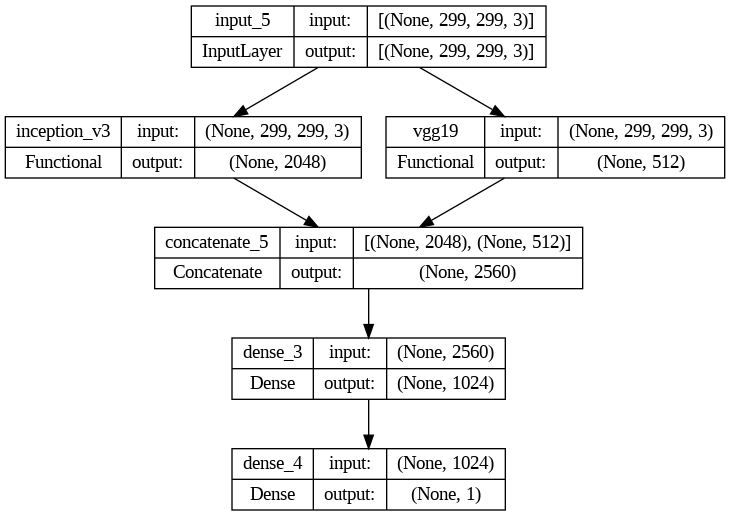

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, VGG19

# Define InceptionV3 model
input_shape = (299, 299, 3)
Input_Layer = layers.Input(shape=input_shape)
base_model1 = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

for layer in base_model1.layers:
    layer.trainable = False;

base_model1 = base_model1(Input_Layer)

# Define VGG19 model
input_shape = (299, 299, 3)
base_model2 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

for layer in base_model2.layers:
    layer.trainable = False;

base_model2 = base_model2(Input_Layer)

# Concatenate the models
concatenated = tf.keras.layers.Concatenate()([base_model1, base_model2])

# Add fully connected layer
x = tf.keras.layers.Dense(1024, activation='relu')(concatenated)

# Add output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the combined model
model= tf.keras.Model(inputs=Input_Layer, outputs=output)

# Compile the model
model.compile(
          loss='binary_crossentropy',
          optimizer=tf.keras.optimizers.Adam(0.001),
          metrics=['acc'])

# Print model summary
model.summary()
keras.utils.plot_model(model, "inceptionV3+VGG19.png", show_shapes=True)

In [ ]:
# from keras.callbacks import ModelCheckpoint

# # define the checkpoint to save the best weights during training
# checkpoint = ModelCheckpoint('combined_model_best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,patience=3, min_lr=0.0001)

callbacks_list = [early,reduce_lr]

# train the model using the training data
history = model.fit(
        x=train_ds,
        validation_data=val_ds,
        epochs=25,
        #shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
26/26 [==============================] - 26s 788ms/step - loss: 0.8823 - acc: 0.7539 - val_loss: 0.2050 - val_acc: 0.9630 - lr: 0.0010
Epoch 2/25
26/26 [==============================] - 19s 714ms/step - loss: 0.1764 - acc: 0.9383 - val_loss: 0.1464 - val_acc: 0.9728 - lr: 0.0010
Epoch 3/25
26/26 [==============================] - 16s 603ms/step - loss: 0.1182 - acc: 0.9618 - val_loss: 0.1919 - val_acc: 0.9210 - lr: 0.0010
Epoch 4/25
26/26 [==============================] - 16s 620ms/step - loss: 0.0842 - acc: 0.9766 - val_loss: 0.1407 - val_acc: 0.9481 - lr: 0.0010
Epoch 5/25
26/26 [==============================] - 16s 627ms/step - loss: 0.0739 - acc: 0.9778 - val_loss: 0.1379 - val_acc: 0.9383 - lr: 0.0010
Epoch 6/25
26/26 [==============================] - 17s 640ms/step - loss: 0.0581 - acc: 0.9827 - val_loss: 0.1034 - val_acc: 0.9556 - lr: 0.0010
Epoch 7/25
26/26 [==============================] - 22s 825ms/step - loss: 0.0485 - acc: 0.9926 - val_loss: 0.1798 - val_acc

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/Saved_models/model_Inception+VGG19_adam.h5')

In [ ]:
# Load the saved model
from keras.models import load_model
model_Inception_VGG19_adam = load_model('/content/drive/MyDrive/STAAR/solved_model/model_Inception+VGG19_adam.h5')

In [ ]:
train_result = model.evaluate(train_ds)
val_result = model.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

7/7 [==============================] - 6s 743ms/step - loss: 0.0449 - acc: 0.9877


,Train,Val
Loss,0.019819,0.044862
Acc,0.997532,0.987654


In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
# # Load the testing dataset
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test'
# img_size = (299, 299)
# batch_size = 64

# test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
# test_data = test_datagen.flow_from_directory(
#               test_dir,
#               shuffle=False,
#               class_mode='binary',
#               target_size=img_size,
#               batch_size=batch_size,
#               classes={'no': 0., 'yes': 1.}
#               )

# # print(test_data.shape)
# test_result = model.evaluate(test_data)
# augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
# augmented_df

Found 210 images belonging to 2 classes.
4/4 [==============================] - 7s 2s/step - loss: 0.3112 - acc: 0.9000


,Test
Loss,0.311185
Acc,0.900000


In [ ]:
# Load the testing dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test1'
img_size = (299, 299)
batch_size = 64

test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
test_data = test_datagen.flow_from_directory(
              test_dir,
              shuffle=False,
              class_mode='binary',
              target_size=img_size,
              batch_size=batch_size,
              classes={'no': 0., 'yes': 1.}
              )

# print(test_data.shape)
test_result = model.evaluate(test_data)
augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
augmented_df

Found 100 images belonging to 2 classes.
2/2 [==============================] - 9s 8s/step - loss: 0.1807 - acc: 0.9600


,Test
Loss,0.180661
Acc,0.960000


## 4.2 InceptionV3 + VGG16
<a class="anchor" id="2"></a>

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 2048)         21802784    ['input_8[0][0]']                
                                                                                                  
 vgg16 (Functional)             (None, 512)          14714688    ['input_8[0][0]']                
                                                                                                  
 concatenate_10 (Concatenat

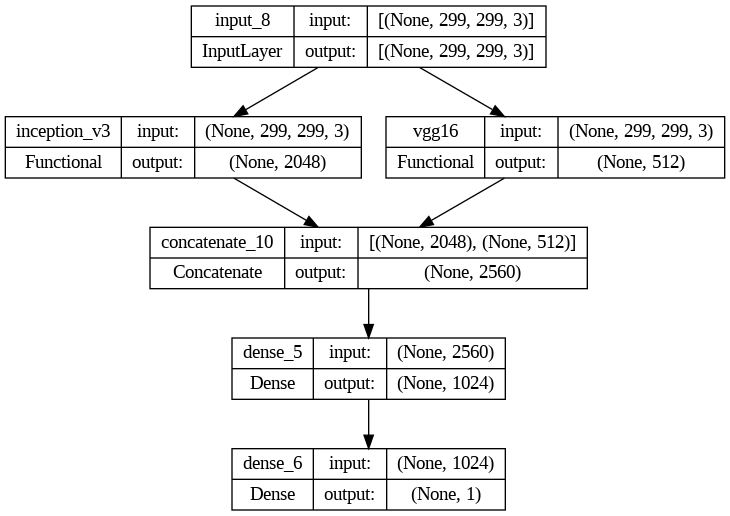

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, VGG16

# Define InceptionV3 model
input_shape = (299, 299, 3)
Input_Layer = layers.Input(shape=input_shape)
base_model1 = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

for layer in base_model1.layers:
    layer.trainable = False;

base_model1 = base_model1(Input_Layer)

# Define VGG19 model
input_shape = (299, 299, 3)
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

for layer in base_model2.layers:
    layer.trainable = False;

base_model2 = base_model2(Input_Layer)

# Concatenate the models
concatenated = tf.keras.layers.Concatenate()([base_model1, base_model2])

# Add fully connected layer
x = tf.keras.layers.Dense(1024, activation='relu')(concatenated)

# Add output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the combined model
model = tf.keras.Model(inputs=Input_Layer, outputs=output)

# Compile the model
model.compile(
          loss='binary_crossentropy',
          optimizer=tf.keras.optimizers.Adam(0.001),
          metrics=['acc'])

# Print model summary
model.summary()
keras.utils.plot_model(model, "inceptionV3+VGG19.png", show_shapes=True)

In [ ]:
# from keras.callbacks import ModelCheckpoint

# # define the checkpoint to save the best weights during training
# checkpoint = ModelCheckpoint('combined_model_best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,patience=3, min_lr=0.0001)

callbacks_list = [early,reduce_lr]

# train the model using the training data
history = model.fit(
        x=train_ds,
        validation_data=val_ds,
        epochs=25,
        #shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
26/26 [==============================] - 388s 14s/step - loss: 1.2453 - acc: 0.6595 - val_loss: 0.3139 - val_acc: 0.9407 - lr: 0.0010
Epoch 2/25
26/26 [==============================] - 15s 571ms/step - loss: 0.2548 - acc: 0.8957 - val_loss: 0.2021 - val_acc: 0.9605 - lr: 0.0010
Epoch 3/25
26/26 [==============================] - 15s 577ms/step - loss: 0.1722 - acc: 0.9371 - val_loss: 0.2829 - val_acc: 0.8444 - lr: 0.0010
Epoch 4/25
26/26 [==============================] - 15s 564ms/step - loss: 0.1375 - acc: 0.9531 - val_loss: 0.2342 - val_acc: 0.8889 - lr: 0.0010
Epoch 5/25
26/26 [==============================] - 18s 669ms/step - loss: 0.1039 - acc: 0.9648 - val_loss: 0.1468 - val_acc: 0.9531 - lr: 0.0010
Epoch 6/25
26/26 [==============================] - 15s 562ms/step - loss: 0.0796 - acc: 0.9766 - val_loss: 0.1238 - val_acc: 0.9605 - lr: 0.0010
Epoch 7/25
26/26 [==============================] - 15s 566ms/step - loss: 0.0664 - acc: 0.9821 - val_loss: 0.1288 - val_acc:

In [ ]:
# model.save('/content/drive/MyDrive/STAAR/solved_model/model_Inception+VGG16_adam.h5')

In [ ]:
# Load the saved model
from keras.models import load_model
model_Inception_VGG16_adam= load_model('/content/drive/MyDrive/STAAR/solved_model/model_Inception+VGG16_adam.h5')

In [ ]:
train_result = model.evaluate(train_ds)
val_result = model.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

7/7 [==============================] - 5s 599ms/step - loss: 0.0324 - acc: 0.9901


,Train,Val
Loss,0.013118,0.032435
Acc,1.000000,0.990123


In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
# # Load the testing dataset
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test'
# img_size = (299, 299)
# batch_size = 64

# test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
# test_data = test_datagen.flow_from_directory(
#               test_dir,
#               shuffle=False,
#               class_mode='binary',
#               target_size=img_size,
#               batch_size=batch_size,
#               classes={'no': 0., 'yes': 1.}
#               )

# # print(test_data.shape)
# test_result = model.evaluate(test_data)
# augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
# augmented_df

Found 210 images belonging to 2 classes.
4/4 [==============================] - 4s 706ms/step - loss: 0.3598 - acc: 0.8714


,Test
Loss,0.359843
Acc,0.871429


In [ ]:
# Load the testing dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test2'
img_size = (299, 299)
batch_size = 64

test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
test_data = test_datagen.flow_from_directory(
              test_dir,
              shuffle=False,
              class_mode='binary',
              target_size=img_size,
              batch_size=batch_size,
              classes={'no': 0., 'yes': 1.}
              )

# print(test_data.shape)
test_result = model.evaluate(test_data)
augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
augmented_df

Found 100 images belonging to 2 classes.
2/2 [==============================] - 1s 419ms/step - loss: 0.2046 - acc: 0.9300


,Test
Loss,0.204557
Acc,0.930000


## 4.2 InceptionV3 + Xception
<a class="anchor" id="2"></a>

83683744/83683744 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 2048)         21802784    ['input_11[0][0]']               
                                                                                                  
 xception (Functional)          (None, 2048)         20861480    ['input_11[0][0]']               
                                                                                                  
 concatenate_13 (Concatenat

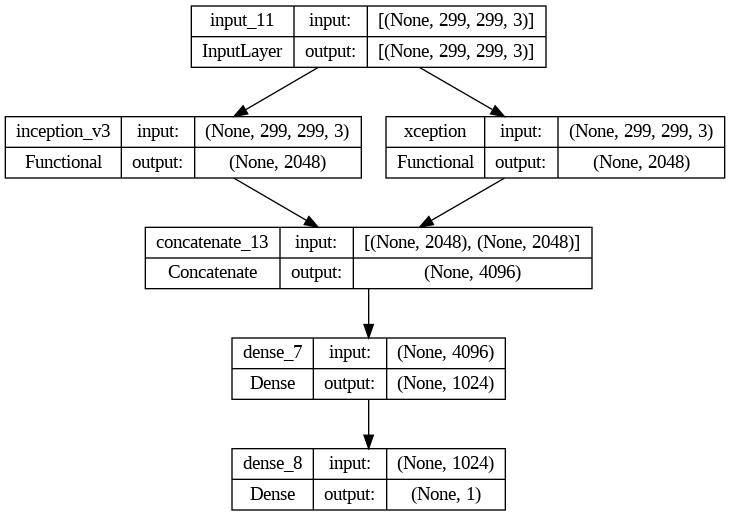

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, Xception

# Define InceptionV3 model
input_shape = (299, 299, 3)
Input_Layer = layers.Input(shape=input_shape)
base_model1 = InceptionV3(include_top=False, input_shape=input_shape, pooling='avg')

for layer in base_model1.layers:
    layer.trainable = False;

base_model1 = base_model1(Input_Layer)
# Define Xception model
input_shape = (299, 299, 3)
base_model2 = Xception(include_top=False, input_shape=input_shape, pooling='avg')

for layer in base_model2.layers:
    layer.trainable = False;

base_model2 = base_model2(Input_Layer)

# Concatenate the models
concatenated = tf.keras.layers.Concatenate()([base_model1, base_model2])

# Add fully connected layer
x = tf.keras.layers.Dense(1024, activation='relu')(concatenated)

# Add output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the combined model
model = tf.keras.Model(inputs=Input_Layer, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.losses.binary_crossentropy,
              metrics=['accuracy'])

# Print model summary
model.summary()
keras.utils.plot_model(model, "inceptionV3+xception.png", show_shapes=True)

In [ ]:
# from keras.callbacks import ModelCheckpoint

# # define the checkpoint to save the best weights during training
# checkpoint = ModelCheckpoint('combined_model_best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,patience=3, min_lr=0.0001)

callbacks_list = [early,reduce_lr]

# train the model using the training data
history = model.fit(
        x=train_ds,
        validation_data=val_ds,
        epochs=25,
        #shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
26/26 [==============================] - ETA: 0s - loss: 1.0977 - accuracy: 0.7526

26/26 [==============================] - 319s 11s/step - loss: 1.0977 - accuracy: 0.7526 - val_loss: 0.1815 - val_accuracy: 0.9457 - lr: 0.0010
Epoch 2/25
26/26 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.9451

26/26 [==============================] - 14s 546ms/step - loss: 0.1500 - accuracy: 0.9451 - val_loss: 0.0939 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 3/25
26/26 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9642

26/26 [==============================] - 14s 538ms/step - loss: 0.0985 - accuracy: 0.9642 - val_loss: 0.1005 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 4/25
26/26 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9741

26/26 [==============================] - 14s 540ms/step - loss: 0.0780 - accuracy: 0.9741 - val_loss: 0.1160 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 5/25
26/26 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9833

26/26 [==============================] - 15s 553ms/step - loss: 0.0590 - accuracy: 0.9833 - val_loss: 0.0909 - val_accuracy: 0.9901 - lr: 0.0010
Epoch 6/25
26/26 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9914

26/26 [==============================] - 17s 637ms/step - loss: 0.0417 - accuracy: 0.9914 - val_loss: 0.0651 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 7/25
26/26 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9938

26/26 [==============================] - 14s 542ms/step - loss: 0.0341 - accuracy: 0.9938 - val_loss: 0.0636 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 8/25
26/26 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9957

26/26 [==============================] - 14s 547ms/step - loss: 0.0319 - accuracy: 0.9957 - val_loss: 0.0486 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 9/25
26/26 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9975

26/26 [==============================] - 14s 538ms/step - loss: 0.0170 - accuracy: 0.9975 - val_loss: 0.0688 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 10/25
26/26 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9994

26/26 [==============================] - 14s 534ms/step - loss: 0.0126 - accuracy: 0.9994 - val_loss: 0.0780 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 11/25
26/26 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9994

26/26 [==============================] - 14s 533ms/step - loss: 0.0092 - accuracy: 0.9994 - val_loss: 0.0679 - val_accuracy: 0.9753 - lr: 0.0010
Epoch 12/25
26/26 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 1.0000

26/26 [==============================] - 14s 531ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0931 - val_accuracy: 0.9654 - lr: 0.0010
Epoch 13/25
26/26 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

26/26 [==============================] - 14s 539ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9901 - lr: 0.0010


In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/Saved_models/model_Inception+Xception_adam.h5')

In [ ]:
# Load the saved model
from keras.models import load_model
model_Inception_Xception_adam = load_model('/content/drive/MyDrive/STAAR/solved_model/model_Inception+Xception_adam.h5')

In [ ]:
train_result = model.evaluate(train_ds)
val_result = model.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

7/7 [==============================] - 4s 574ms/step - loss: 0.0255 - acc: 0.9975


,Train,Val
Loss,0.006064,0.025451
Acc,1.000000,0.997531


In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
# # Load the testing dataset
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test'
# img_size = (299, 299)
# batch_size = 64

# test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
# test_data = test_datagen.flow_from_directory(
#               test_dir,
#               shuffle=False,
#               class_mode='binary',
#               target_size=img_size,
#               batch_size=batch_size,
#               classes={'no': 0., 'yes': 1.}
#               )

# # print(test_data.shape)
# test_result = model.evaluate(test_data)
# augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
# augmented_df

Found 210 images belonging to 2 classes.
4/4 [==============================] - 4s 1s/step - loss: 0.2556 - acc: 0.8762


,Test
Loss,0.255562
Acc,0.876190


In [ ]:
# Load the testing dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test2'
img_size = (299, 299)
batch_size = 64

test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
test_data = test_datagen.flow_from_directory(
              test_dir,
              shuffle=False,
              class_mode='binary',
              target_size=img_size,
              batch_size=batch_size,
              classes={'no': 0., 'yes': 1.}
              )

# print(test_data.shape)
test_result = model.evaluate(test_data)
augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
augmented_df

Found 100 images belonging to 2 classes.
2/2 [==============================] - 5s 4s/step - loss: 0.1669 - acc: 0.9200


,Test
Loss,0.166869
Acc,0.920000


## VGG19+ADAM


<a class="anchor" id="2"></a>

In [ ]:
from keras.layers.preprocessing import normalization
# VGG19
height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_VGG19_adam= tf.keras.Sequential()
model_VGG19_adam.add(base_model)
model_VGG19_adam.add(tf.keras.layers.Flatten())
model_VGG19_adam.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_VGG19_adam.compile(
                    loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_VGG19_adam.summary()

Found 1621 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 1)                 41473     
                                                                 
Total params: 20,065,857
Trainable params: 41,473
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,patience=3, min_lr=0.0000001)

callbacks_list = [early,reduce_lr]

history = model_VGG19_adam.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        #shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
26/26 [==============================] - 672s 25s/step - loss: 0.4426 - acc: 0.8186 - val_loss: 0.2317 - val_acc: 0.9062 - lr: 0.0010
Epoch 2/25
26/26 [==============================] - 21s 778ms/step - loss: 0.1279 - acc: 0.9568 - val_loss: 0.1346 - val_acc: 0.9827 - lr: 0.0010
Epoch 3/25
26/26 [==============================] - 19s 726ms/step - loss: 0.0829 - acc: 0.9741 - val_loss: 0.1980 - val_acc: 0.9383 - lr: 0.0010
Epoch 4/25
26/26 [==============================] - 22s 837ms/step - loss: 0.0661 - acc: 0.9821 - val_loss: 0.1201 - val_acc: 0.9827 - lr: 0.0010
Epoch 5/25
26/26 [==============================] - 20s 765ms/step - loss: 0.0496 - acc: 0.9907 - val_loss: 0.0675 - val_acc: 0.9926 - lr: 0.0010
Epoch 6/25
26/26 [==============================] - 20s 780ms/step - loss: 0.0386 - acc: 0.9957 - val_loss: 0.0917 - val_acc: 0.9827 - lr: 0.0010
Epoch 7/25
26/26 [==============================] - 20s 766ms/step - loss: 0.0346 - acc: 0.9957 - val_loss: 0.0615 - val_acc:

In [ ]:
# model_VGG19_adam.save('/content/drive/MyDrive/STAAR/model_VGG19_adam_adam.h5')

In [ ]:
# Load the saved model
from keras.models import load_model
model_VGG19_adam = load_model('/content/drive/MyDrive/STAAR/solved_model/model_VGG19_adam_adam.h5')

In [ ]:
train_result = model_VGG19_adam.evaluate(train_ds)
val_result = model_VGG19_adam.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

7/7 [==============================] - 4s 484ms/step - loss: 0.0328 - acc: 0.9951


,Train,Val
Loss,0.007146,0.032845
Acc,1.000000,0.995062


In [ ]:
# # Load the testing dataset
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test'
# img_size = (299, 299)
# batch_size = 64

# test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
# test_data = test_datagen.flow_from_directory(
#               test_dir,
#               shuffle=False,
#               class_mode='binary',
#               target_size=img_size,
#               batch_size=batch_size,
#               classes={'no': 0., 'yes': 1.}
#               )

# # print(test_data.shape)
# test_result = model_VGG19_adam.evaluate(test_data)
# augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
# augmented_df

Found 210 images belonging to 2 classes.
4/4 [==============================] - 2s 459ms/step - loss: 0.4135 - acc: 0.8571


,Test
Loss,0.413518
Acc,0.857143


In [ ]:
# Load the testing dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test2'
img_size = (299, 299)
batch_size = 64

test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
test_data = test_datagen.flow_from_directory(
              test_dir,
              shuffle=False,
              class_mode='binary',
              target_size=img_size,
              batch_size=batch_size,
              classes={'no': 0., 'yes': 1.}
              )

# print(test_data.shape)
test_result = model_VGG19_adam.evaluate(test_data)
augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
augmented_df

Found 100 images belonging to 2 classes.
2/2 [==============================] - 1s 367ms/step - loss: 0.2173 - acc: 0.9100


,Test
Loss,0.217325
Acc,0.910000


In [ ]:
ypred = model_VGG19_adam.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

## VGG16+XECEPTION
<a class="anchor" id="2"></a>

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 512)          14714688    ['input_2[0][0]']                
                                                                                                  
 xception (Functional)          (None, 2048)         20861480    ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 2560)         0           ['vgg16[0][0]',              

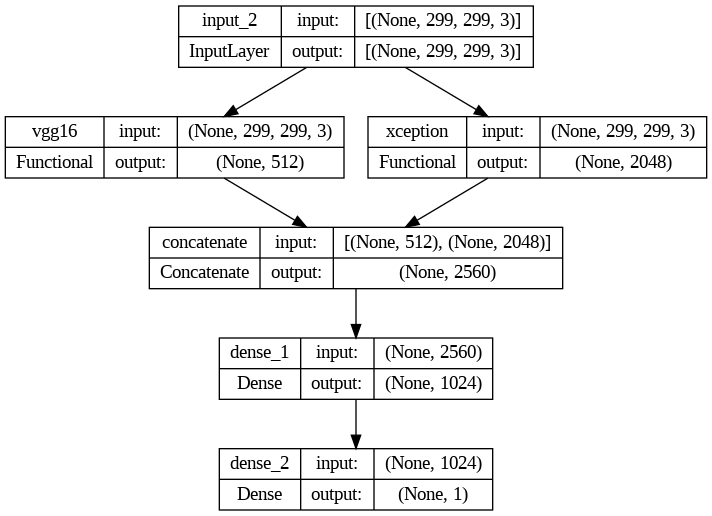

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, Xception
from keras.callbacks import EarlyStopping

# Define VGG16 model
input_shape = (299, 299, 3)
Input_Layer = layers.Input(shape=input_shape)
base_model1 = VGG16(include_top=False, input_shape=input_shape, pooling='avg')

for layer in base_model1.layers:
    layer.trainable = False;

base_model1 = base_model1(Input_Layer)
# Define Xception model
input_shape = (299, 299, 3)
base_model2 = Xception(include_top=False, input_shape=input_shape, pooling='avg')

for layer in base_model2.layers:
    layer.trainable = False;

base_model2 = base_model2(Input_Layer)

# Concatenate the models
concatenated = tf.keras.layers.Concatenate()([base_model1, base_model2])

# Add fully connected layer
x = tf.keras.layers.Dense(1024, activation='relu')(concatenated)

# Add output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the combined model
model = tf.keras.Model(inputs=Input_Layer, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.losses.binary_crossentropy,
              metrics=['accuracy'])

# Print model summary
model.summary()
keras.utils.plot_model(model, "VGG16+xception.png", show_shapes=True)

In [ ]:
# aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,patience=3, min_lr=0.0000001)

callbacks_list = [early,reduce_lr]

history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        #shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
26/26 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.7995 

26/26 [==============================] - 1334s 51s/step - loss: 0.5720 - accuracy: 0.7995 - val_loss: 0.1693 - val_accuracy: 0.9580 - lr: 0.0010
Epoch 2/25
26/26 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9476

26/26 [==============================] - 17s 641ms/step - loss: 0.1435 - accuracy: 0.9476 - val_loss: 0.1104 - val_accuracy: 0.9753 - lr: 0.0010
Epoch 3/25
26/26 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9642

26/26 [==============================] - 19s 730ms/step - loss: 0.1041 - accuracy: 0.9642 - val_loss: 0.0911 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 4/25
26/26 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9766

26/26 [==============================] - 17s 637ms/step - loss: 0.0732 - accuracy: 0.9766 - val_loss: 0.0969 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 5/25
26/26 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9833

26/26 [==============================] - 16s 625ms/step - loss: 0.0593 - accuracy: 0.9833 - val_loss: 0.0914 - val_accuracy: 0.9802 - lr: 0.0010
Epoch 6/25
26/26 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9889

26/26 [==============================] - 17s 636ms/step - loss: 0.0410 - accuracy: 0.9889 - val_loss: 0.0444 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 7/25
26/26 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9914

26/26 [==============================] - 17s 639ms/step - loss: 0.0336 - accuracy: 0.9914 - val_loss: 0.0630 - val_accuracy: 0.9901 - lr: 0.0010
Epoch 8/25
26/26 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9969

26/26 [==============================] - 17s 647ms/step - loss: 0.0224 - accuracy: 0.9969 - val_loss: 0.0531 - val_accuracy: 0.9901 - lr: 0.0010
Epoch 9/25
26/26 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9988

26/26 [==============================] - 19s 708ms/step - loss: 0.0165 - accuracy: 0.9988 - val_loss: 0.0854 - val_accuracy: 0.9654 - lr: 0.0010
Epoch 10/25
26/26 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9994

26/26 [==============================] - 17s 662ms/step - loss: 0.0140 - accuracy: 0.9994 - val_loss: 0.0325 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 11/25
26/26 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 1.0000

26/26 [==============================] - 19s 727ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0702 - val_accuracy: 0.9679 - lr: 0.0010
Epoch 12/25
26/26 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 1.0000

26/26 [==============================] - 17s 638ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0355 - val_accuracy: 0.9951 - lr: 0.0010
Epoch 13/25
26/26 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000

26/26 [==============================] - 19s 711ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0470 - val_accuracy: 0.9901 - lr: 0.0010
Epoch 14/25
26/26 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

26/26 [==============================] - 19s 700ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0802 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 15/25
26/26 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

26/26 [==============================] - 17s 641ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0368 - val_accuracy: 0.9951 - lr: 0.0010


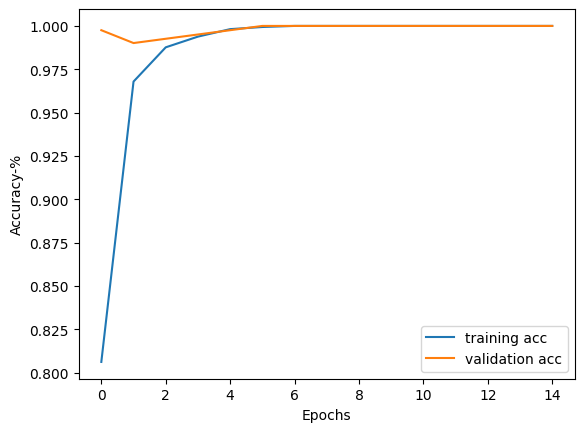

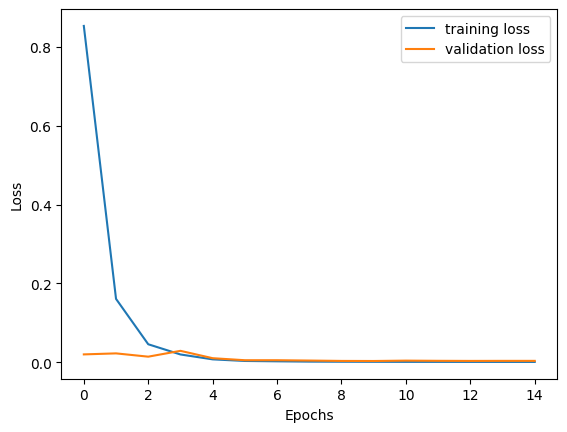

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
# model.save('/content/drive/MyDrive/STAAR/solved_model/model_VGG19_XCEPTION.h5')

In [ ]:
# Load the saved model
from keras.models import load_model
model_VGG16_XCEPTION = load_model('/content/drive/MyDrive/STAAR/solved_model/model_VGG19_XCEPTION.h5')

In [ ]:
train_result = model.evaluate(train_ds)
val_result = model.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

7/7 [==============================] - 6s 817ms/step - loss: 0.0734 - accuracy: 0.9778


,Train,Val
Loss,0.136050,0.073375
Acc,0.951265,0.977778


In [ ]:
# Load the testing dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test2'
img_size = (299, 299)
batch_size = 64

test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
test_data = test_datagen.flow_from_directory(
              test_dir,
              shuffle=False,
              class_mode='binary',
              target_size=img_size,
              batch_size=batch_size,
              classes={'no': 0., 'yes': 1.}
              )

# print(test_data.shape)
test_result = model.evaluate(test_data)
augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
augmented_df

Found 100 images belonging to 2 classes.
2/2 [==============================] - 2s 575ms/step - loss: 0.7763 - accuracy: 0.7500


,Test
Loss,0.776266
Acc,0.750000


vgg16

In [ ]:
from keras.layers.preprocessing import normalization
# VGG16
height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_VGG16_adam= tf.keras.Sequential()
model_VGG16_adam.add(base_model)
model_VGG16_adam.add(tf.keras.layers.Flatten())
model_VGG16_adam.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_VGG16_adam.compile(
                    loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_VGG16_adam.summary()

Found 1621 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 1)                 41473     
                                                                 
Total params: 14,756,161
Trainable params: 41,473
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#  aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,patience=3, min_lr=0.0000001)

callbacks_list = [early,reduce_lr]

history = model_VGG16_adam.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        #shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
26/26 [==============================] - 23s 866ms/step - loss: 0.5303 - acc: 0.7637 - val_loss: 0.2035 - val_acc: 0.9160 - lr: 0.0010
Epoch 2/25
26/26 [==============================] - 19s 735ms/step - loss: 0.1497 - acc: 0.9550 - val_loss: 0.0892 - val_acc: 0.9852 - lr: 0.0010
Epoch 3/25
26/26 [==============================] - 19s 723ms/step - loss: 0.0841 - acc: 0.9741 - val_loss: 0.0897 - val_acc: 0.9852 - lr: 0.0010
Epoch 4/25
26/26 [==============================] - 18s 653ms/step - loss: 0.0633 - acc: 0.9827 - val_loss: 0.0571 - val_acc: 0.9926 - lr: 0.0010
Epoch 5/25
26/26 [==============================] - 19s 732ms/step - loss: 0.0446 - acc: 0.9920 - val_loss: 0.0582 - val_acc: 0.9926 - lr: 0.0010
Epoch 6/25
26/26 [==============================] - 18s 666ms/step - loss: 0.0361 - acc: 0.9938 - val_loss: 0.0511 - val_acc: 0.9926 - lr: 0.0010
Epoch 7/25
26/26 [==============================] - 17s 660ms/step - loss: 0.0308 - acc: 0.9957 - val_loss: 0.0445 - val_acc

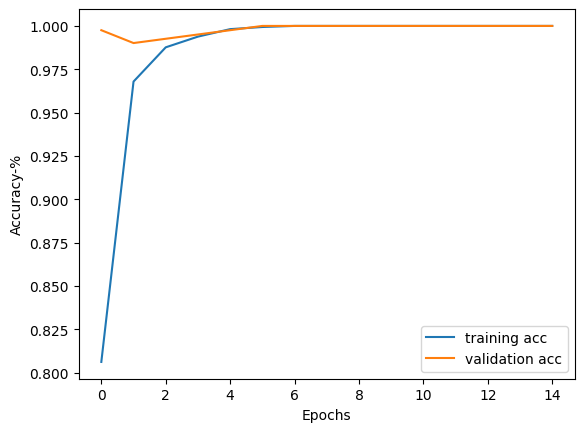

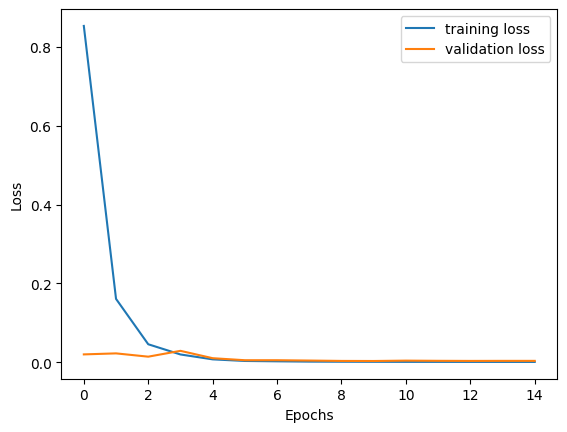

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
# model_VGG16_adam.save('/content/drive/MyDrive/STAAR/model_VGG16_adam_adam.h5')

In [ ]:
# Load the saved model
from keras.models import load_model
model_VGG16_adam = load_model('/content/drive/MyDrive/STAAR/solved_model/model_VGG16_adam_adam.h5')

In [ ]:
# Load the testing dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test2'
img_size = (299, 299)
batch_size = 64

test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
test_data = test_datagen.flow_from_directory(
              test_dir,
              shuffle=False,
              class_mode='binary',
              target_size=img_size,
              batch_size=batch_size,
              classes={'no': 0., 'yes': 1.}
              )

# print(test_data.shape)
test_result = model_VGG16_adam.evaluate(test_data)
augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
augmented_df

Found 100 images belonging to 2 classes.
2/2 [==============================] - 1s 318ms/step - loss: 0.2055 - acc: 0.9000


,Test
Loss,0.205521
Acc,0.900000


In [ ]:
ypred = model_VGG16_adam.predict(test_data[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = test_data[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

2/2 [==============================] - 0s 283ms/step
Confusion_Matrix:
 [[50  0]
 [ 0 14]]

Classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        14

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



## DENSENET+ADAM
<a class="anchor" id="2"></a>

Found 1621 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 9, 9, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 1)                 82945     
                                                                 
Total params: 7,120,449
Trainable params: 82,945
Non-trainable params: 7,037,504
_________________________________________________________________


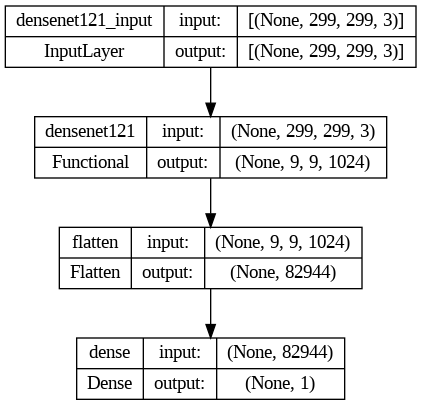

In [ ]:
from keras.layers.preprocessing import normalization

height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_DenseNet_adam= tf.keras.Sequential()
model_DenseNet_adam.add(base_model)
model_DenseNet_adam.add(tf.keras.layers.Flatten())
model_DenseNet_adam.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_DenseNet_adam.compile(
                    loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_DenseNet_adam.summary()
keras.utils.plot_model(model_DenseNet_adam, "inceptionV3+xception.png", show_shapes=True)

In [ ]:
# aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,patience=3, min_lr=0.00001)

callbacks_list = [early,reduce_lr]

history = model_DenseNet_adam.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        #shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
26/26 [==============================] - 47s 1s/step - loss: 1.6435 - acc: 0.7878 - val_loss: 0.0238 - val_acc: 0.9975 - lr: 0.0010
Epoch 2/25
26/26 [==============================] - 16s 617ms/step - loss: 0.3223 - acc: 0.9513 - val_loss: 0.0187 - val_acc: 0.9926 - lr: 0.0010
Epoch 3/25
26/26 [==============================] - 19s 737ms/step - loss: 0.1354 - acc: 0.9747 - val_loss: 0.0119 - val_acc: 0.9975 - lr: 0.0010
Epoch 4/25
26/26 [==============================] - 16s 600ms/step - loss: 0.0627 - acc: 0.9864 - val_loss: 0.0187 - val_acc: 0.9951 - lr: 0.0010
Epoch 5/25
26/26 [==============================] - 16s 611ms/step - loss: 0.0109 - acc: 0.9963 - val_loss: 0.0079 - val_acc: 0.9951 - lr: 0.0010
Epoch 6/25
26/26 [==============================] - 16s 617ms/step - loss: 0.0035 - acc: 0.9994 - val_loss: 0.0066 - val_acc: 0.9951 - lr: 0.0010
Epoch 7/25
26/26 [==============================] - 16s 608ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1

In [ ]:
train_result = model_DenseNet_adam.evaluate(train_ds)
val_result = model_DenseNet_adam.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

7/7 [==============================] - 4s 556ms/step - loss: 0.0028 - acc: 1.0000


,Train,Val
Loss,0.000647,0.002793
Acc,1.000000,1.000000


In [ ]:
# model_DenseNet_adam.save('/content/drive/MyDrive/STAAR/solved_model/model_DenseNet_adam.h5')

In [ ]:
# Load the saved model
from keras.models import load_model
model_DenseNet_adam = load_model('/content/drive/MyDrive/STAAR/solved_model/model_DenseNet_adam.h5')

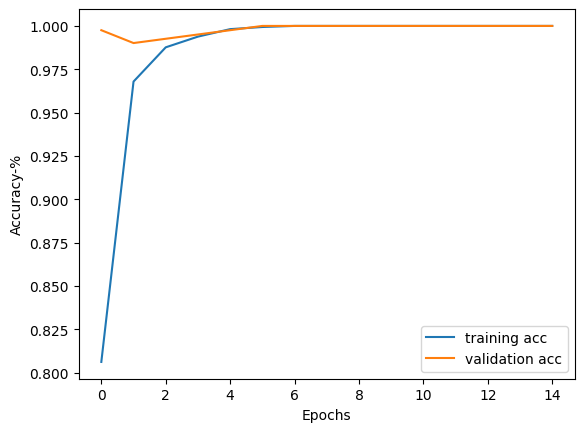

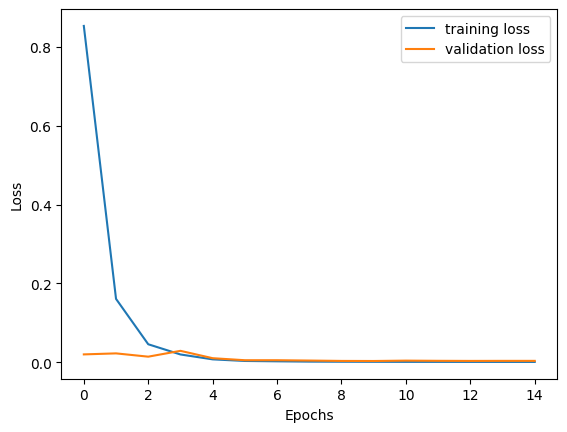

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
# Load the testing dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test1'
img_size = (299, 299)
batch_size = 64

test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
test_ds = test_datagen.flow_from_directory(
              test_dir,
              shuffle=False,
              class_mode='binary',
              target_size=img_size,
              batch_size=batch_size,
              classes={'no': 0., 'yes': 1.}
              )

# print(test_data.shape)
test_result = model_DenseNet_adam.evaluate(test_ds)
augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
augmented_df

Found 200 images belonging to 2 classes.
4/4 [==============================] - 14s 930ms/step - loss: 0.2934 - acc: 0.9200


,Test
Loss,0.293391
Acc,0.920000


In [ ]:
# # Load the testing dataset
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test1'
# img_size = (299, 299)
# batch_size = 64

# test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
# test_data = test_datagen.flow_from_directory(
#               test_dir,
#               shuffle=True,
#               class_mode='binary',
#               target_size=img_size,
#               batch_size=batch_size,
#               classes={'no': 0., 'yes': 1.}
#               )

# # # print(test_data.shape)
# # test_result = model_DenseNet_adam.evaluate(test_data)
# # augmented_df = pd.DataFrame(zip(test_result),columns=['Test'],index=['Loss','Acc'])
# # augmented_df


Found 200 images belonging to 2 classes.


In [ ]:
# Load the testing dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/STAAR/new_Brain_tumor/test1'
img_size = (224, 224)
batch_size = 64

test_datagen = ImageDataGenerator(rescale=1./255) # or any other desired preprocessing
test_data2 = test_datagen.flow_from_directory(
              test_dir,
              shuffle=True,
              class_mode='binary',
              target_size=img_size,
              batch_size=batch_size,
              classes={'no': 0., 'yes': 1.}
              )

Found 200 images belonging to 2 classes.


2/2 [==============================] - 0s 156ms/step


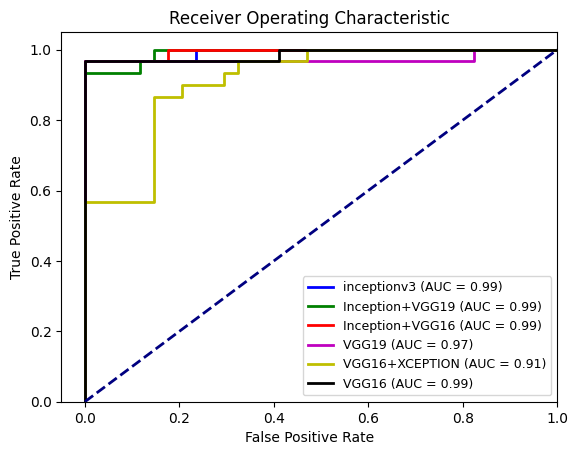

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have predicted probabilities and true labels for each model
model1_predictions = model_inceptionv3_adam.predict(test_data[0][0])
model2_predictions = model_Inception_VGG19_adam.predict(test_data[0][0])
model3_predictions = model_Inception_VGG16_adam.predict(test_data[0][0])
model4_predictions = model_Inception_Xception_adam.predict(test_data[0][0])
model5_predictions = model_VGG19_adam.predict(test_data[0][0])
model6_predictions = model_VGG16_XCEPTION.predict(test_data[0][0])
model7_predictions = model_VGG16_adam.predict(test_data[0][0])
model8_predictions = model_DenseNet_adam.predict(test_data[0][0])


# true_labels = test_data.labels # Replace with true labels for the test dataset

ytest = test_data[0][-1]

true_labels = ytest

# List to store the FPR, TPR, and AUC for each model
fpr_list = []
tpr_list = []
auc_list = []

# Compute ROC curves and AUC for each model
for predictions in [model1_predictions, model2_predictions, model3_predictions, model4_predictions, model5_predictions, model6_predictions, model7_predictions, model8_predictions]:
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    auc_score = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc_score)

# Plot the ROC curves for each model
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray']

plt.plot(fpr_list[0], tpr_list[0], color=colors[0], lw=2, label=f'inceptionv3 (AUC = {auc_list[0]:.2f})')
plt.plot(fpr_list[1], tpr_list[1], color=colors[1], lw=2, label=f'Inception+VGG19 (AUC = {auc_list[1]:.2f})')
plt.plot(fpr_list[2], tpr_list[2], color=colors[2], lw=2, label=f'Inception+VGG16 (AUC = {auc_list[2]:.2f})')
# plt.plot(fpr_list[3], tpr_list[3], color=colors[3], lw=2, label=f'Inception+Xception (AUC = {auc_list[3]:.2f})')
plt.plot(fpr_list[4], tpr_list[4], color=colors[4], lw=2, label=f'VGG19 (AUC = {auc_list[4]:.2f})')
plt.plot(fpr_list[5], tpr_list[5], color=colors[5], lw=2, label=f'VGG16+XCEPTION (AUC = {auc_list[5]:.2f})')
plt.plot(fpr_list[6], tpr_list[6], color=colors[6], lw=2, label=f'VGG16 (AUC = {auc_list[6]:.2f})')
# plt.plot(fpr_list[7], tpr_list[7], color=colors[7], lw=2, label=f'DenseNet (AUC = {auc_list[7]:.2f})')

# Plot the random classifier line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot properties
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(fontsize="9",loc='lower right')

# Show the plot
plt.show()

2/2 [==============================] - 0s 155ms/step


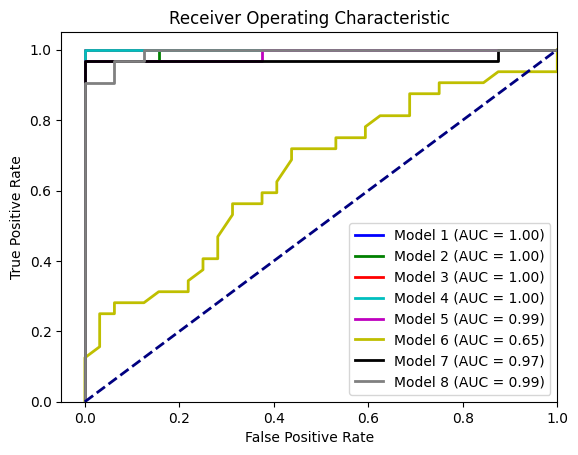

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc

# # Assuming you have predicted probabilities and true labels for each model
# model1_predictions = model_inceptionv3_adam.predict(test_data[0][0])
# model2_predictions = model_Inception_VGG19_adam.predict(test_data[0][0])
# model3_predictions = model_Inception_VGG16_adam.predict(test_data[0][0])
# model4_predictions = model_Inception_Xception_adam.predict(test_data[0][0])
# model5_predictions = model_VGG19_adam.predict(test_data[0][0])
# model6_predictions = model_VGG16_XCEPTION.predict(test_data2[0][0])
# model7_predictions = model_VGG16_adam.predict(test_data[0][0])
# model8_predictions = model_DenseNet_adam.predict(test_data[0][0])


# # true_labels = test_data.labels # Replace with true labels for the test dataset

# ytest = test_data[0][-1]

# true_labels = ytest

# # List to store the FPR, TPR, and AUC for each model
# fpr_list = []
# tpr_list = []
# auc_list = []

# # Compute ROC curves and AUC for each model
# for predictions in [model1_predictions, model2_predictions, model3_predictions, model4_predictions, model5_predictions, model6_predictions, model7_predictions, model8_predictions]:
#     fpr, tpr, _ = roc_curve(true_labels, predictions)
#     auc_score = auc(fpr, tpr)
#     fpr_list.append(fpr)
#     tpr_list.append(tpr)
#     auc_list.append(auc_score)

# # Plot the ROC curves for each model
# plt.figure()
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray']
# for i in range(len(fpr_list)):
#     plt.plot(fpr_list[i], tpr_list[i], color=colors[i], lw=2, label=f'Model {i+1} (AUC = {auc_list[i]:.2f})')
#     # plt.plot(fpr_list[i], tpr_list[i], color=colors[i], lw=2, label=f'Model {i+1}')

# # Plot the random classifier line
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# # Set plot properties
# plt.xlim([-0.05, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc='lower right')

# # Show the plot
# plt.show()